# 単軸駆動時のVppピークサーチ方法の検討
<div style="text-align: right;">　2023/01/12 園田慎一郎　</div>

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
folder = "./single_peak_search_data/WP1"
files = glob.glob(folder + "/*.txt")

In [3]:
f = open(files[1], 'r')
data = f.read()
f.close()

In [4]:
def data_to_dict(data):
    slow_freq_list = np.array([int(_i) for _i in data.split("slow_freq_list[bit]")[1].\
                      split("slow_phase_list[clk]")[0].split("[")[1].split("]")[0].split(",")])
    slow_phase_list = np.array([float(_i) for _i in data.split("slow_phase_list[clk]")[1].\
                       split("slow_vpp_list[bit]")[0].split("[")[1].split("]")[0].split(",")])
    slow_vpp_list = np.array([float(_i) for _i in data.split("slow_vpp_list[bit]")[1].\
                     split("temperature[deg]")[0].split("[")[1].split("]")[0].split(",")])
    
    fast_freq_list = np.array([int(_i) for _i in data.split("slow_freq_list[bit]")[2].\
                      split("slow_phase_list[clk]")[0].split("[")[1].split("]")[0].split(",")])
    fast_phase_list = np.array([float(_i) for _i in data.split("slow_phase_list[clk]")[2].\
                       split("slow_vpp_list[bit]")[0].split("[")[1].split("]")[0].split(",")])
    fast_vpp_list = np.array([float(_i) for _i in data.split("slow_vpp_list[bit]")[2].\
                     split("temperature[deg]")[0].split("[")[1].split("]")[0].split(",")])

    sample_name = data.split("Sample_name")[1].split("res[bit]")[0].split(":")[1][2:-4]
    temperature = float(data.split("temperature[deg]")[1].split("humid[%]")[0].split(":")[1][1:-3])
    humidity = float(data.split("humid[%]")[1].split("}")[0][3:])
    
    return {"sample_name": sample_name,\
             "slow_freq_list": slow_freq_list, "slow_phase_list": slow_phase_list, "slow_vpp_list": slow_vpp_list,\
             "fast_freq_list": fast_freq_list, "fast_phase_list": fast_phase_list, "fast_vpp_list": fast_vpp_list,\
             "temperature":  temperature, "humidity": humidity}

In [5]:
ex_data = data_to_dict(data)

## (1) 元のデータ

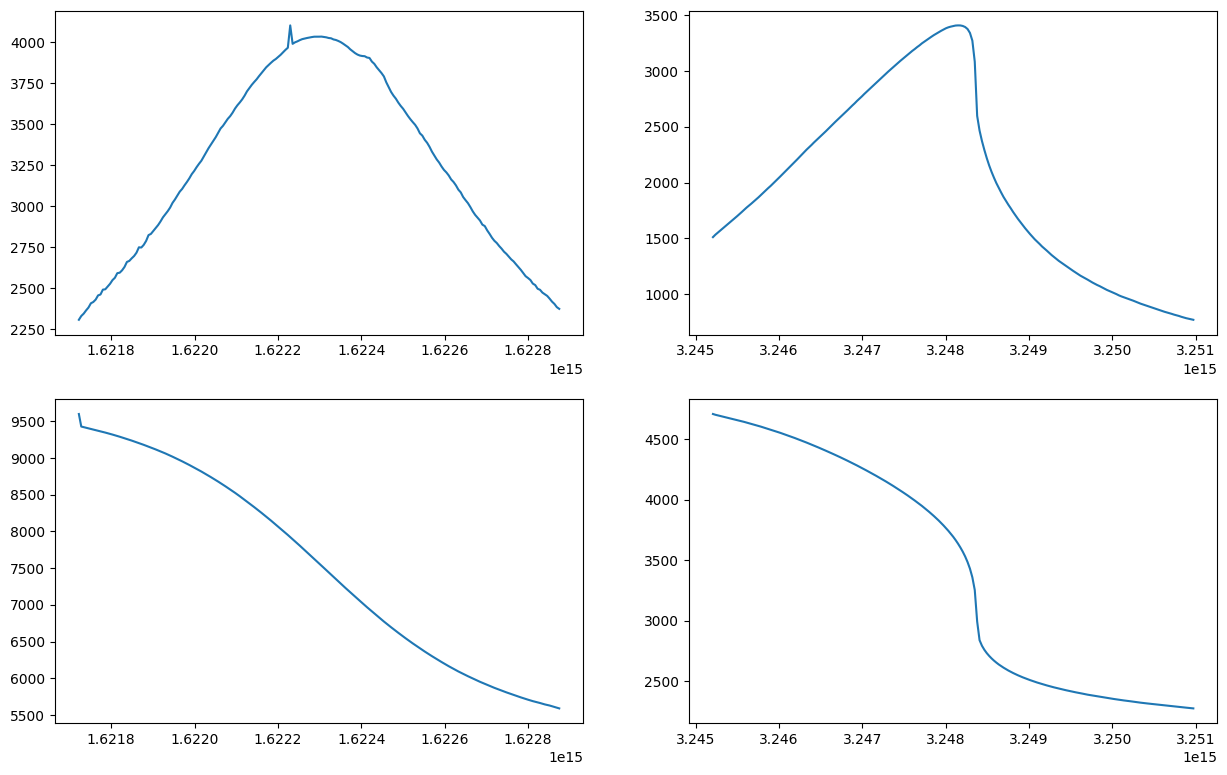

In [6]:
graph_list = [["slow_freq_list", "slow_vpp_list"], ["fast_freq_list", "fast_vpp_list"],\
              ["slow_freq_list", "slow_phase_list"], ["fast_freq_list", "fast_phase_list"]]

fig = plt.figure(figsize=(15,90))
[rows, cols] = [18,2]

axs = [ fig.add_subplot(rows, cols, i) for i in range(1,5) ]

for i, ax in enumerate(axs):
    ax.plot(ex_data[graph_list[i][0]], ex_data[graph_list[i][1]])

## (2) Smootingを行った場合

In [7]:
def smoothing(y , num=5):
    b=np.ones(num)/num
    return np.convolve(y, b, mode='same')

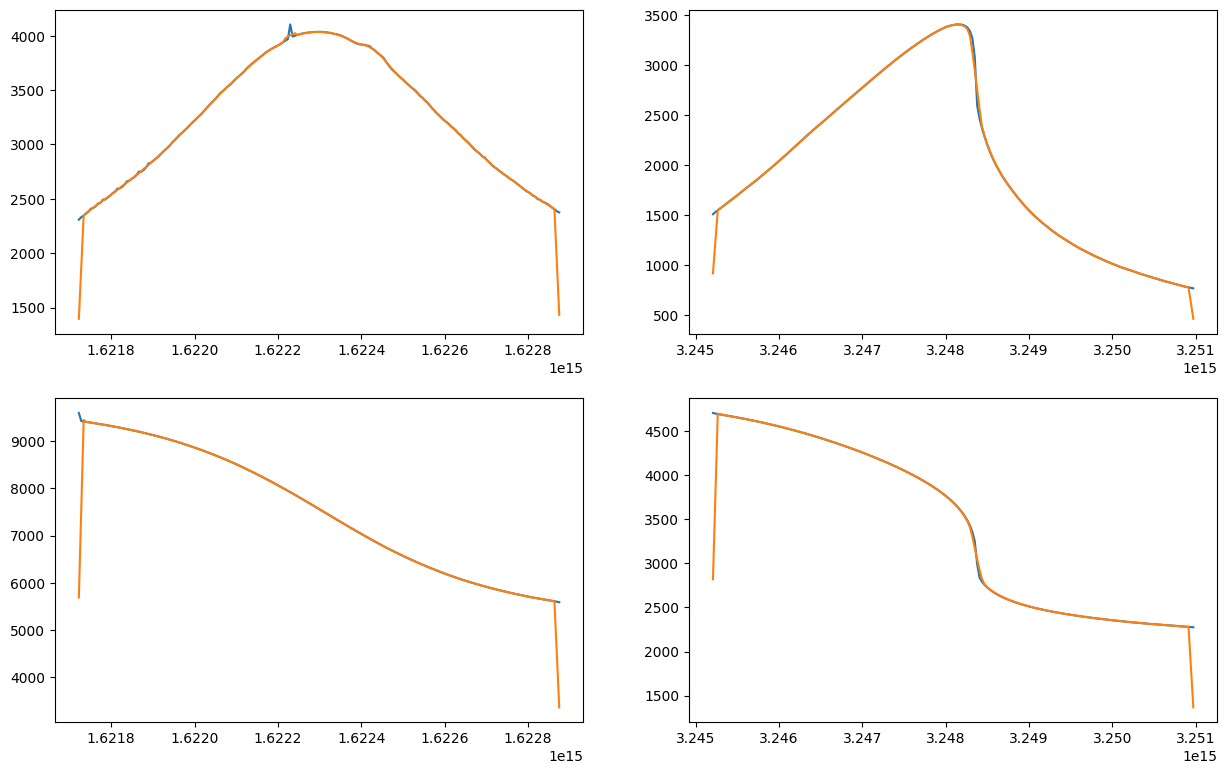

In [8]:
fig = plt.figure(figsize=(15,90))
axs = [ fig.add_subplot(rows, cols, i) for i in range(1,5) ]

for i, ax in enumerate(axs):
    ax.plot(ex_data[graph_list[i][0]], ex_data[graph_list[i][1]])
    ax.plot(ex_data[graph_list[i][0]], smoothing(ex_data[graph_list[i][1]]))

## (3) 1D Median Filterを使用した場合 

In [9]:
def median1d(arr, k=5):
    w = len(arr)
    idx = np.fromfunction(lambda i, j: i + j, (k, w), dtype=np.int32) - k // 2
    idx[idx < 0] = 0
    idx[idx > w - 1] = w - 1
    return np.median(arr[idx], axis=0)

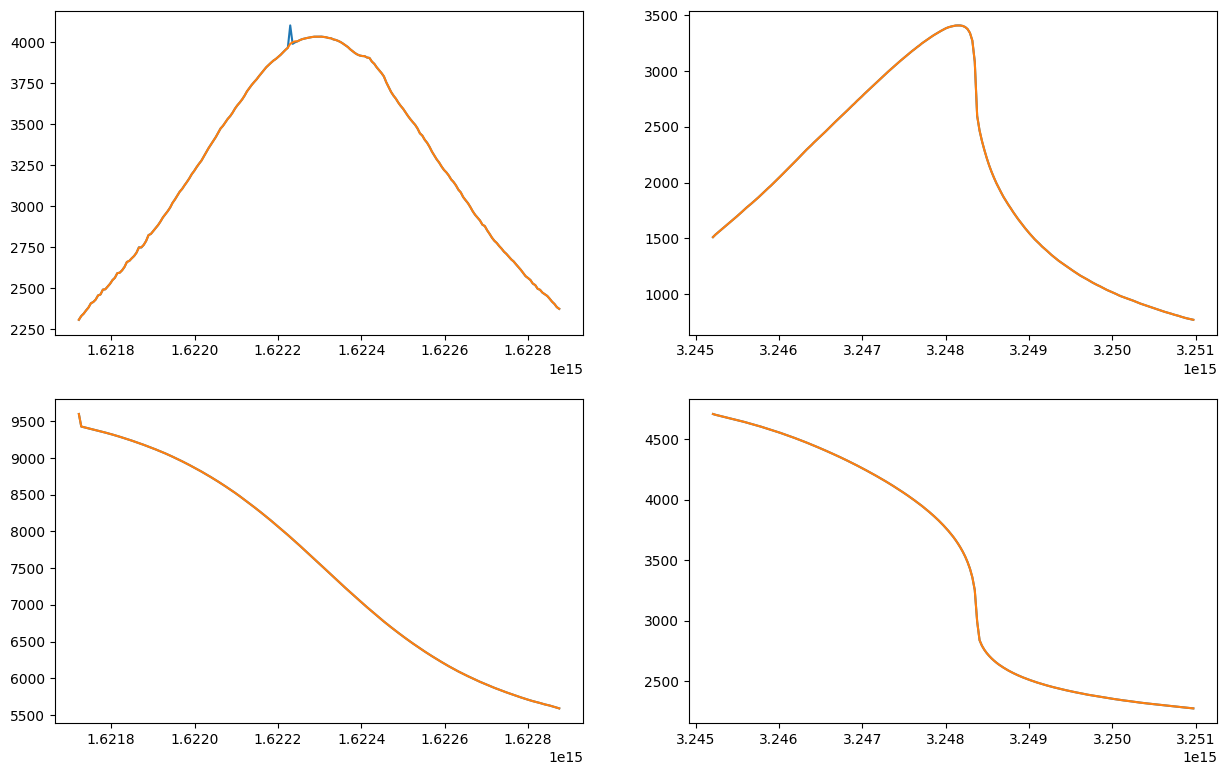

In [10]:
fig = plt.figure(figsize=(15,90))
axs = [ fig.add_subplot(rows, cols, i) for i in range(1,5) ]

for i, ax in enumerate(axs):
    ax.plot(ex_data[graph_list[i][0]], ex_data[graph_list[i][1]])
    ax.plot(ex_data[graph_list[i][0]], median1d(ex_data[graph_list[i][1]]))

## (4) ピークサーチの方法 （最大値）

In [11]:
def peak_serch(x_data, y_data):
    x = x_data[np.where(y_data==np.max(y_data))[0]][0]
    y = y_data[np.where(y_data==np.max(y_data))[0]][0]
    return x, y

normal:  1622229732272111 4104.188
median: 1622293142954864 4035.286
normal:  3248148813358962 3409.69
median: 3248119990321347 3408.386
normal:  1621722446810087 9599.45
median: 1621722446810087 9599.45
normal:  3245208863522232 4706.182
median: 3245208863522232 4706.182


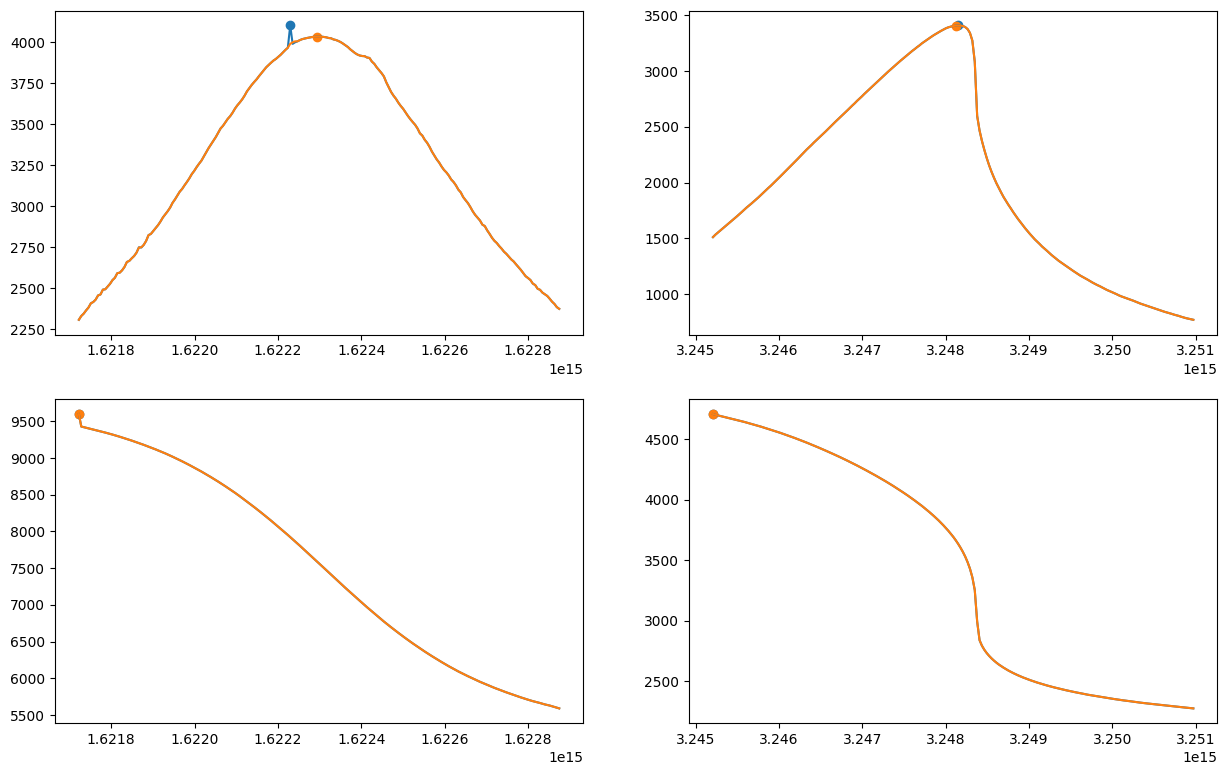

In [12]:
fig = plt.figure(figsize=(15,90))
axs = [ fig.add_subplot(rows, cols, i) for i in range(1,5) ]

for i, ax in enumerate(axs):
    ax.plot(ex_data[graph_list[i][0]], ex_data[graph_list[i][1]])
    x, y = peak_serch(ex_data[graph_list[i][0]], ex_data[graph_list[i][1]])
    ax.scatter(x, y)
    print("normal: ", x, y)
    
    ax.plot(ex_data[graph_list[i][0]], median1d(ex_data[graph_list[i][1]]))
    x, y = peak_serch(ex_data[graph_list[i][0]],  median1d(ex_data[graph_list[i][1]]))
    ax.scatter(x, y)
    print("median:", x, y)

## データの差分

In [13]:
def diff_data(data):
    diff_data = [(data[_j+1] - data[_j]) for _j in range(0,len(data)-1,1)]
    diff_data.append(data[len(data) - 1] - data[len(data) - 2])
    return np.array(diff_data)

In [14]:
ex_data["slow_phase_diff_list"] = diff_data(ex_data["slow_phase_list"])
ex_data["fast_phase_diff_list"] = diff_data(ex_data["fast_phase_list"])

In [15]:
graph_list = [["slow_freq_list", "slow_phase_list"], ["fast_freq_list", "fast_phase_list"],\
              ["slow_freq_list", "slow_phase_diff_list"], ["fast_freq_list", "fast_phase_diff_list"]]

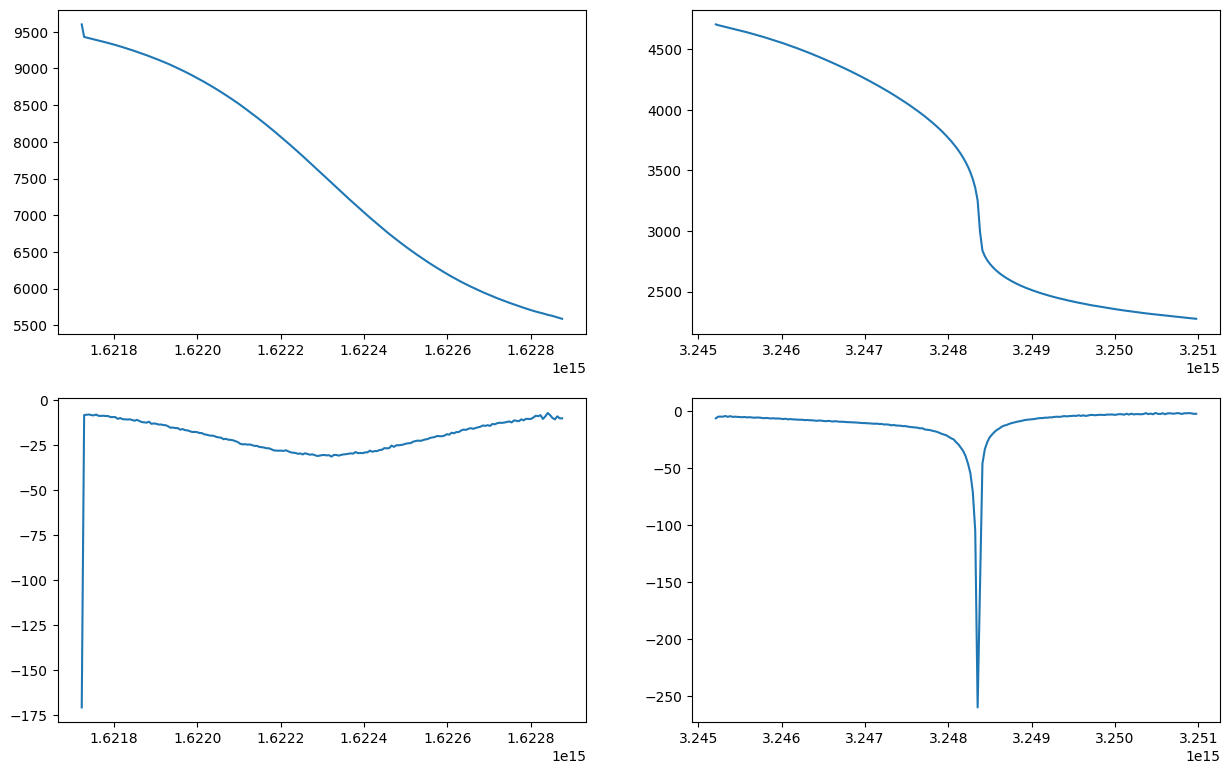

In [16]:
fig = plt.figure(figsize=(15,90))
axs = [ fig.add_subplot(rows, cols, i) for i in range(1,5) ]


for i, ax in enumerate(axs):
    ax.plot(ex_data[graph_list[i][0]], ex_data[graph_list[i][1]])

In [17]:
graph_list1 = [["slow_freq_list", "slow_vpp_list"], ["fast_freq_list", "fast_vpp_list"]]
graph_list2 = [["slow_freq_list", "slow_phase_diff_list"], ["fast_freq_list", "fast_phase_diff_list"]]

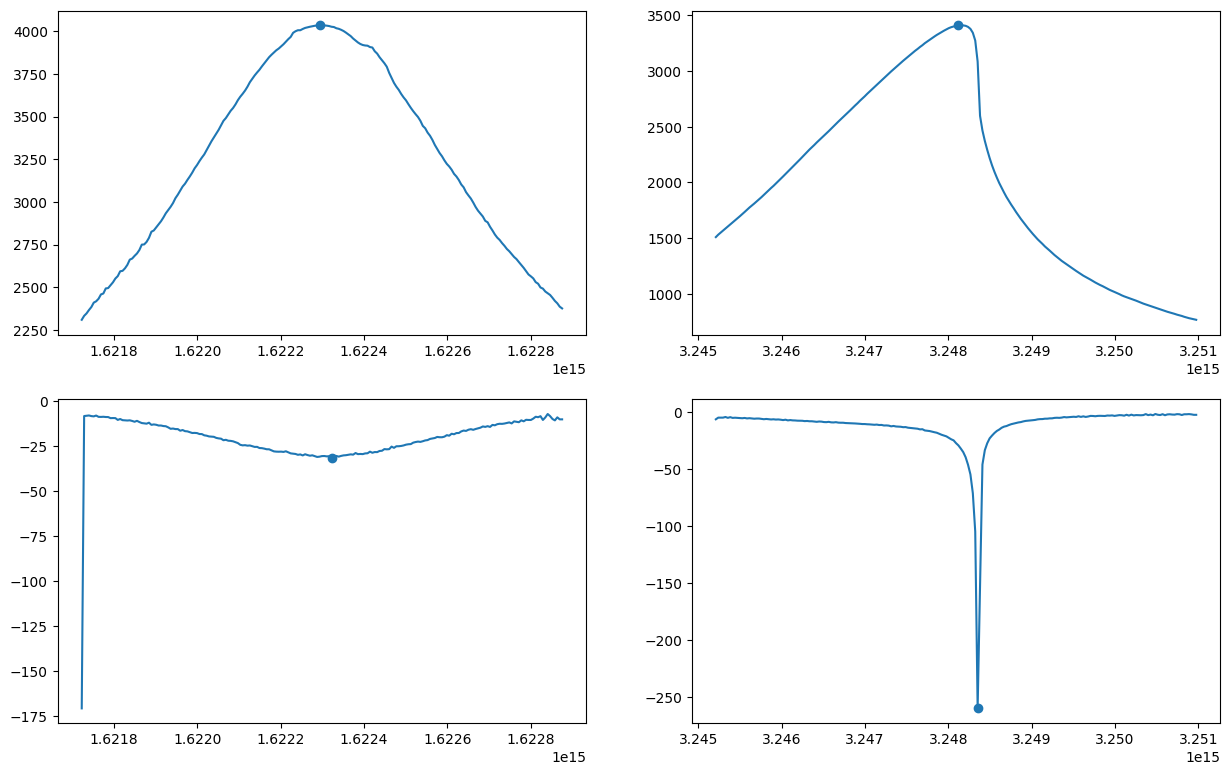

In [18]:
fig = plt.figure(figsize=(15,90))
axs = [ fig.add_subplot(rows, cols, i) for i in range(1,5) ]
ignore_num = 10

for i, ax in enumerate(axs[:-2]):
    ax.plot(ex_data[graph_list1[i][0]], median1d(ex_data[graph_list1[i][1]]))
    x, y = peak_serch(ex_data[graph_list1[i][0]], median1d(ex_data[graph_list1[i][1]]))
    ax.scatter(x, y)
    
for i, ax in enumerate(axs[-2:]):
    ax.plot(ex_data[graph_list2[i][0]], ex_data[graph_list2[i][1]])
    x, y = ex_data[graph_list2[i][0]][np.argmin(ex_data[graph_list2[i][1]][ignore_num:-ignore_num]) + ignore_num],\
           ex_data[graph_list2[i][1]][np.argmin(ex_data[graph_list2[i][1]][ignore_num:-ignore_num]) + ignore_num]
    ax.scatter(x, y)

## 共振の位相値を決める。

In [19]:
def get_res_pos(data, th):
    return np.where((data > th*0.99) & (data < th*1.01))[0][0]

In [20]:
graph_list3 = [["slow_freq_list", "slow_phase_list", 7500], ["fast_freq_list", "fast_phase_list", 3250]]

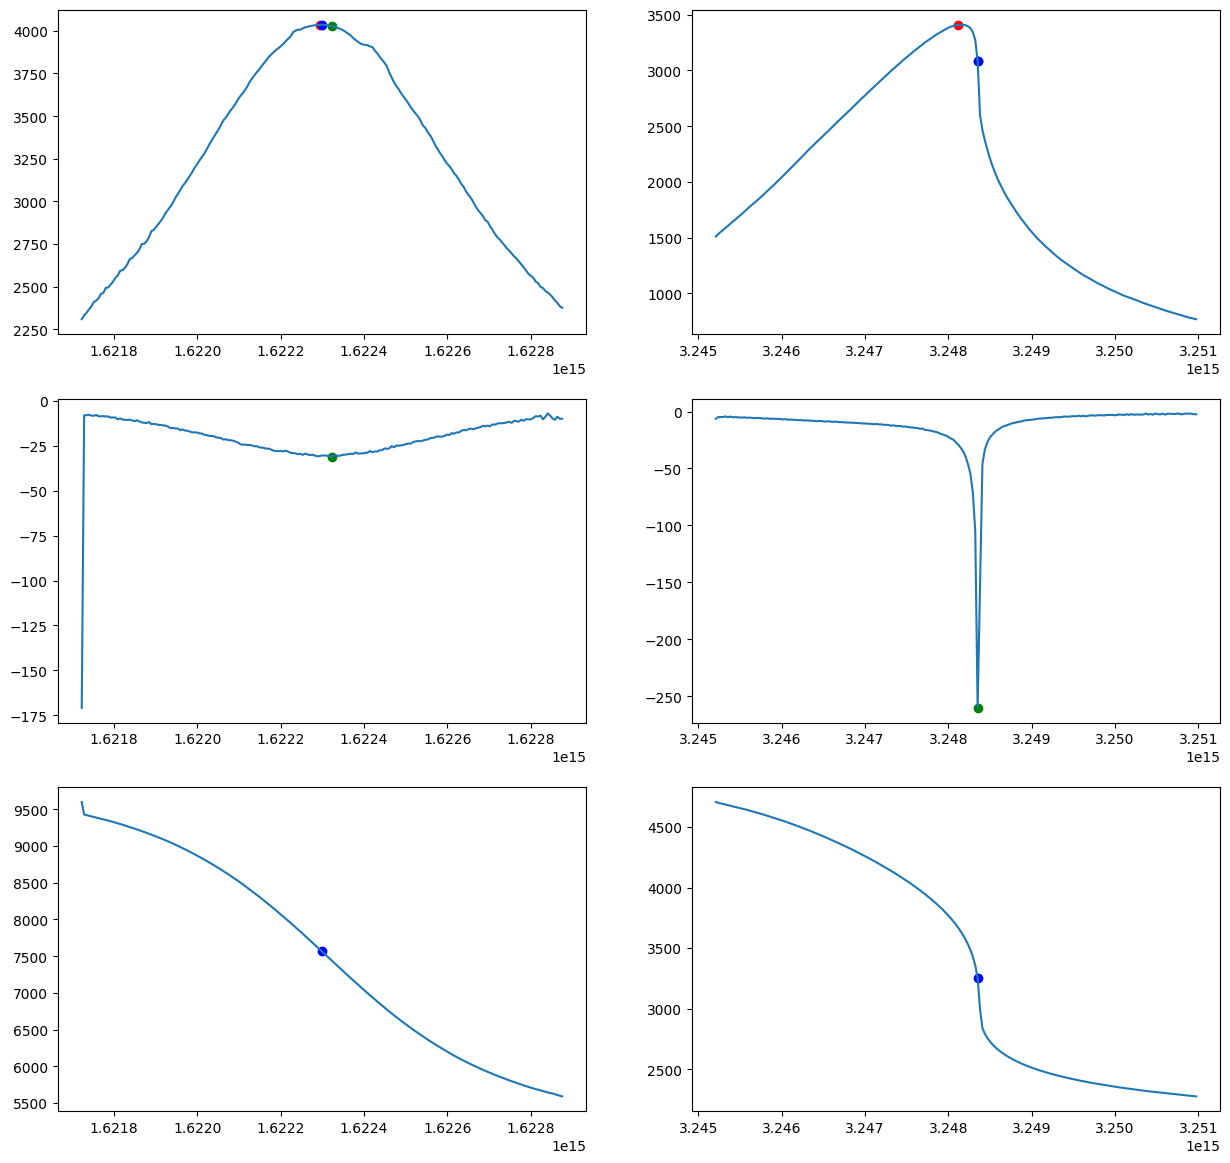

In [21]:
fig = plt.figure(figsize=(15,90))
axs = [ fig.add_subplot(rows, cols, i) for i in range(1,7) ]
ignore_num = 10

for i, ax in enumerate(axs[:-4]):
    ax.plot(ex_data[graph_list1[i][0]], median1d(ex_data[graph_list1[i][1]]))
    x, y = peak_serch(ex_data[graph_list1[i][0]], median1d(ex_data[graph_list1[i][1]]))
    ax.scatter(x, y, c='r')
    x, y = ex_data[graph_list2[i][0]][np.argmin(ex_data[graph_list2[i][1]][ignore_num:-ignore_num]) + ignore_num],\
           ex_data[graph_list1[i][1]][np.argmin(ex_data[graph_list2[i][1]][ignore_num:-ignore_num]) + ignore_num]
    ax.scatter(x, y, c='g')
    x, y = ex_data[graph_list2[i][0]][get_res_pos(ex_data[graph_list3[i][1]], graph_list3[i][2])],\
           ex_data[graph_list1[i][1]][get_res_pos(ex_data[graph_list3[i][1]], graph_list3[i][2])]
    ax.scatter(x, y, c='b')
    
for i, ax in enumerate(axs[-4:-2]):
    ax.plot(ex_data[graph_list2[i][0]], ex_data[graph_list2[i][1]])
    x, y = ex_data[graph_list2[i][0]][np.argmin(ex_data[graph_list2[i][1]][ignore_num:-ignore_num]) + ignore_num],\
           ex_data[graph_list2[i][1]][np.argmin(ex_data[graph_list2[i][1]][ignore_num:-ignore_num]) + ignore_num]
    ax.scatter(x, y, c='g')
    
for i, ax in enumerate(axs[-2:]):
    ax.plot(ex_data[graph_list3[i][0]], ex_data[graph_list3[i][1]])
    x, y = ex_data[graph_list3[i][0]][get_res_pos(ex_data[graph_list3[i][1]], graph_list3[i][2])],\
           ex_data[graph_list3[i][1]][get_res_pos(ex_data[graph_list3[i][1]], graph_list3[i][2])]
    ax.scatter(x, y, c='b')